<a href="https://colab.research.google.com/github/PANYAMLIKITHA/ds_likitha/blob/main/TRADE_BEHAVIOUR_INSIGHTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup & Imports**

In [ ]:
!pip install --quiet gdown seaborn xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, warnings
from matplotlib.dates import DateFormatter
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")

# Directories
OUT_ROOT = "/content/ds_LIKITHA"
CSV_DIR = os.path.join(OUT_ROOT, "csv_files")
OUTS = os.path.join(OUT_ROOT, "outputs")
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUTS, exist_ok=True)


**DIRECTLY DOWNLOAD FROM GOOGLE DRIVE**

In [ ]:
!pip install gdown

import gdown
os.makedirs("/content/ds_data", exist_ok=True)

# Replace with your file IDs
HYPERLIQUID_FILE_ID = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
FEARGREED_FILE_ID   = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

gdown.download(f"https://drive.google.com/uc?id={HYPERLIQUID_FILE_ID}", "/content/ds_data/hyperliquid_trades.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={FEARGREED_FILE_ID}", "/content/ds_data/fear_greed.csv", quiet=False)

HYPERLIQUID_CSV = "/content/ds_data/hyperliquid_trades.csv"
FEARGREED_CSV   = "/content/ds_data/fear_greed.csv"


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/ds_data/hyperliquid_trades.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/ds_data/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 3.05MB/s]


**Load Hyperliquid Trades Dataset**

In [ ]:
trades = pd.read_csv(HYPERLIQUID_CSV)
fear = pd.read_csv(FEARGREED_CSV)

print("Trades shape:", trades.shape)
print("Fear/Greed shape:", fear.shape)


Trades shape: (211224, 16)
Fear/Greed shape: (2644, 4)


**Clean Hyperliquid Trades**

In [ ]:
trades = trades.rename(columns={
    "Account": "account",
    "Coin": "symbol",
    "Execution Price": "execution_price",
    "Size Tokens": "size",
    "Size USD": "size_usd",
    "Side": "side",
    "Timestamp IST": "timestamp_ist",
    "Closed PnL": "closedPnL"
})

# Parse time (IST format: dd-mm-YYYY HH:MM)
trades["time"] = pd.to_datetime(
    trades["timestamp_ist"], format="%d-%m-%Y %H:%M", errors="coerce"
)
trades["trade_date"] = trades["time"].dt.floor("D")

print("Trades after cleaning:")
display(trades.head())


Trades after cleaning:


,account,symbol,execution_price,size,size_usd,side,timestamp_ist,Start Position,Direction,closedPnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,time,trade_date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02


**Load Fear/Greed Dataset**

In [ ]:
FEARGREED_CSV = "/content/ds_data/fear_greed.csv"
fear = pd.read_csv(FEARGREED_CSV)

print("Fear dataset shape:", fear.shape)
display(fear.head())


Fear dataset shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


**Clean Fear/Greed Dataset**

In [ ]:
fear = fear.rename(columns={
    "value": "fear_index",
    "classification": "fear_class",
    "date": "fear_date"
})

fear["fear_date"] = pd.to_datetime(fear["fear_date"], errors="coerce")
fear["trade_date"] = fear["fear_date"].dt.floor("D")

# Extend into 2024 to match trades
last_fear = fear.sort_values("fear_date").iloc[-1]
fear_future = pd.date_range(start="2024-01-01", end=trades["trade_date"].max(), freq="D")
fear_future = pd.DataFrame({
    "trade_date": fear_future,
    "fear_index": last_fear["fear_index"],
    "fear_class": last_fear["fear_class"]
})
fear = pd.concat([fear, fear_future], ignore_index=True)

print("Fear dataset after extension:")
display(fear.tail())


Fear dataset after extension:


,timestamp,fear_index,fear_class,fear_date,trade_date
4100,NaN,67,Greed,NaT,2025-04-27
4101,NaN,67,Greed,NaT,2025-04-28
4102,NaN,67,Greed,NaT,2025-04-29
4103,NaN,67,Greed,NaT,2025-04-30
4104,NaN,67,Greed,NaT,2025-05-01


**Merge Trades + Sentiment**

In [ ]:
merged = trades.merge(
    fear[["trade_date","fear_index","fear_class"]],
    on="trade_date",
    how="left"
)

print("Merged dataset shape:", merged.shape)
display(merged.head())


Merged dataset shape: (422098, 20)


,account,symbol,execution_price,size,size_usd,side,timestamp_ist,Start Position,Direction,closedPnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,time,trade_date,fear_index,fear_class
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,80,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,67,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,80,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,67,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,80,Extreme Greed


**Exploratory Data Analysis (EDA)**

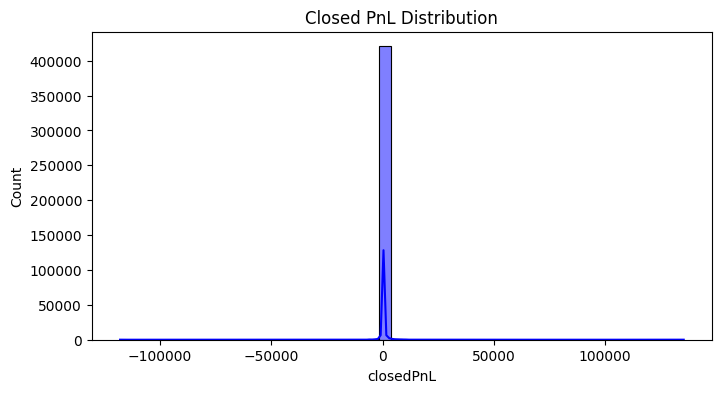

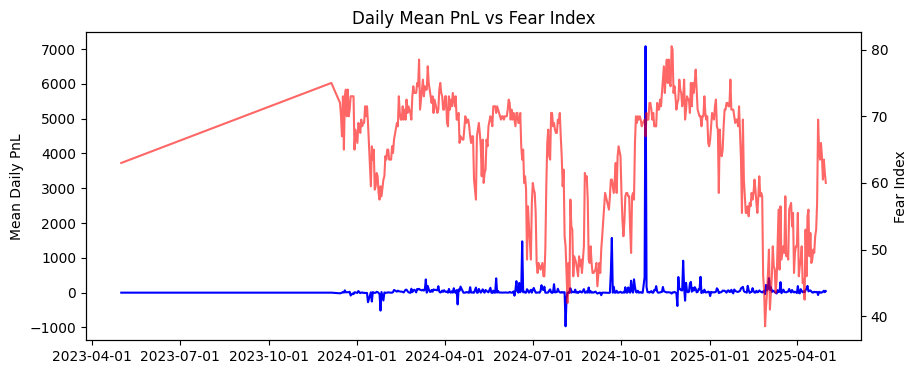

In [ ]:
# PnL Histogram
if "closedPnL" in merged.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(merged["closedPnL"], bins=50, kde=True, color="blue")
    plt.title("Closed PnL Distribution")
    plt.savefig(os.path.join(OUTS,"pnl_distribution.png"))
    plt.show()

# Daily PnL vs Fear Index
if "closedPnL" in merged.columns:
    daily = merged.groupby("trade_date").agg(
        mean_pnl=("closedPnL","mean"),
        mean_fear=("fear_index","mean")
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.plot(daily["trade_date"], daily["mean_pnl"], color="blue")
    ax1.set_ylabel("Mean Daily PnL")

    ax2 = ax1.twinx()
    ax2.plot(daily["trade_date"], daily["mean_fear"], color="red", alpha=0.6)
    ax2.set_ylabel("Fear Index")

    ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
    plt.title("Daily Mean PnL vs Fear Index")
    plt.savefig(os.path.join(OUTS,"pnl_vs_fear.png"))
    plt.show()


**Sentiment Analysis**

In [ ]:
# Performance by Sentiment
if "closedPnL" in merged.columns:
    perf = merged.groupby("fear_class").agg(
        count=("closedPnL","count"),
        mean_pnl=("closedPnL","mean"),
        median_pnl=("closedPnL","median"),
        win_rate=("closedPnL", lambda s: (s>0).mean())
    ).reset_index()

    print("Performance by Sentiment:\n", perf)
    perf.to_csv(os.path.join(CSV_DIR,"performance_by_sentiment.csv"), index=False)

# Performance by Regime
if "closedPnL" in merged.columns:
    merged["fear_regime"] = pd.cut(
        merged["fear_index"], bins=[-1,30,60,101], labels=["HighFear","Neutral","Greed"]
    )
    regime_perf = merged.groupby("fear_regime")["closedPnL"].agg(["count","mean","median"]).reset_index()
    print("Regime Performance:\n", regime_perf)
    regime_perf.to_csv(os.path.join(CSV_DIR,"regime_performance.csv"), index=False)


Performance by Sentiment:
       fear_class   count   mean_pnl  median_pnl  win_rate
0   Extreme Fear   21400  34.537862         0.0  0.370607
1  Extreme Greed   39992  67.892861         0.0  0.464943
2           Fear   61837  54.290400         0.0  0.420768
3          Greed  261183  47.648860         0.0  0.406248
4        Neutral   37686  34.307718         0.0  0.396991
Regime Performance:
   fear_regime   count       mean  median
0    HighFear   43926  31.444486     0.0
1     Neutral   86674  52.112381     0.0
2       Greed  291498  50.262475     0.0


**Modeling (XGBoost)**

In [ ]:
# Feature engineering
merged["signed_size"] = merged["size"] * np.where(merged["side"].str.upper()=="BUY",1,-1)
merged["notional"] = merged["execution_price"] * merged["size"]
merged["leverage"] = 1

# Modeling
if "closedPnL" in merged.columns:
    df_model = merged.dropna(subset=["closedPnL"]).copy()
    df_model["target_profitable"] = (df_model["closedPnL"] > 0).astype(int)

    features = ["notional","signed_size","fear_index","leverage"]
    X = df_model[features].fillna(0)
    y = df_model["target_profitable"]
    groups = df_model["account"]

    clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        n_estimators=50,
        max_depth=5,
        random_state=42
    )

    gkf = GroupKFold(n_splits=5)
    aucs = []
    for train_idx, test_idx in gkf.split(X,y,groups):
        clf.fit(X.iloc[train_idx], y.iloc[train_idx])
        preds = clf.predict_proba(X.iloc[test_idx])[:,1]
        aucs.append(roc_auc_score(y.iloc[test_idx], preds))

    print("\nCross-validated ROC-AUC:", np.mean(aucs))

    fi = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
    print("\nFeature Importance:\n", fi)
    fi.to_csv(os.path.join(CSV_DIR,"feature_importance.csv"))



Cross-validated ROC-AUC: 0.6661498340036891

Feature Importance:
 signed_size    0.460004
notional       0.333260
fear_index     0.206736
leverage       0.000000
dtype: float32


**Advanced Analysis**

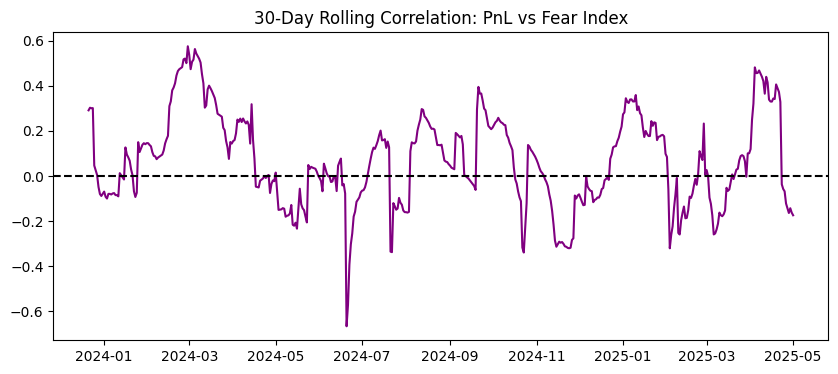

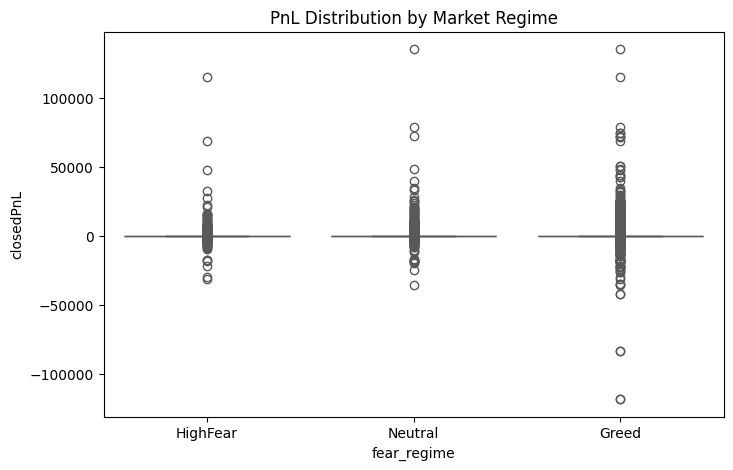

In [ ]:
# Rolling correlation
daily["rolling_corr"] = daily["mean_pnl"].rolling(30, min_periods=10).corr(daily["mean_fear"])
plt.figure(figsize=(10,4))
plt.plot(daily["trade_date"], daily["rolling_corr"], color="purple")
plt.axhline(0, color="black", linestyle="--")
plt.title("30-Day Rolling Correlation: PnL vs Fear Index")
plt.savefig(os.path.join(OUTS,"rolling_correlation.png"))
plt.show()

# Boxplot by regime
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x="fear_regime", y="closedPnL", palette="Set2")
plt.title("PnL Distribution by Market Regime")
plt.savefig(os.path.join(OUTS,"pnl_by_regime_boxplot.png"))
plt.show()


**Dataset Overview**

In [ ]:
# --- Trades Dataset Overview ---
print("📊 Trades Dataset Summary")
print(trades.info())
print("\nMissing Values (Trades):\n", trades.isnull().sum())

# --- Fear Dataset Overview ---
print("\n📊 Fear/Greed Dataset Summary")
print(fear.info())
print("\nMissing Values (Fear/Greed):\n", fear.isnull().sum())


📊 Trades Dataset Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   account           211224 non-null  object        
 1   symbol            211224 non-null  object        
 2   execution_price   211224 non-null  float64       
 3   size              211224 non-null  float64       
 4   size_usd          211224 non-null  float64       
 5   side              211224 non-null  object        
 6   timestamp_ist     211224 non-null  object        
 7   Start Position    211224 non-null  float64       
 8   Direction         211224 non-null  object        
 9   closedPnL         211224 non-null  float64       
 10  Transaction Hash  211224 non-null  object        
 11  Order ID          211224 non-null  int64         
 12  Crossed           211224 non-null  bool          
 13  Fee               211224 non-null 

**Top Traders by Profitability**

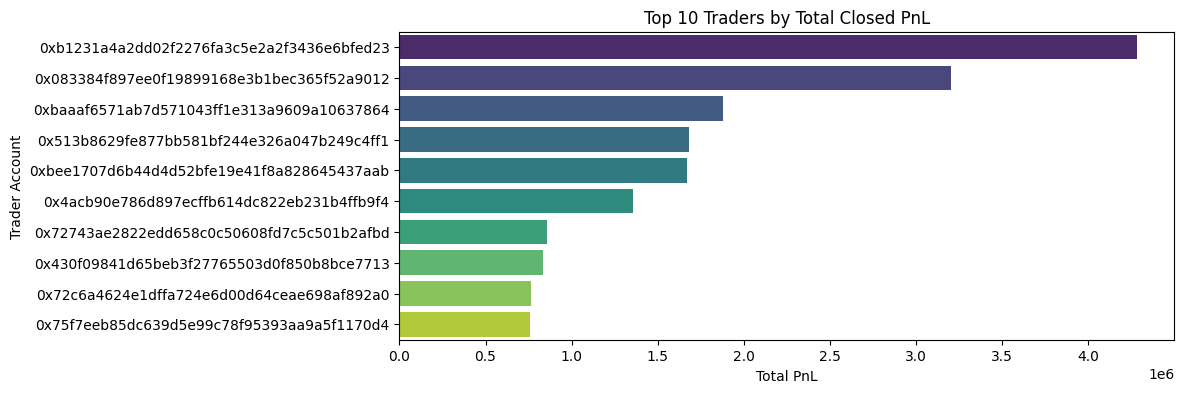

In [ ]:
if "closedPnL" in merged.columns:
    top_traders = merged.groupby("account")["closedPnL"].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,4))
    sns.barplot(x=top_traders.values, y=top_traders.index, palette="viridis")
    plt.title("Top 10 Traders by Total Closed PnL")
    plt.xlabel("Total PnL")
    plt.ylabel("Trader Account")
    plt.savefig(os.path.join(OUTS,"top_traders.png"))
    plt.show()


**Sentiment Distribution**

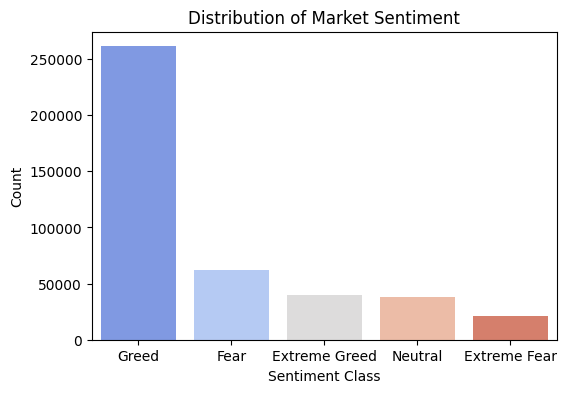

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=merged, x="fear_class", order=merged["fear_class"].value_counts().index, palette="coolwarm")
plt.title("Distribution of Market Sentiment")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.savefig(os.path.join(OUTS,"sentiment_distribution.png"))
plt.show()


In [ ]:
# --- Performance by sentiment ---
if "closedPnL" in merged.columns:
    summary = merged.groupby("fear_class").agg(
        count=("closedPnL","count"),
        mean_pnl=("closedPnL","mean"),
        median_pnl=("closedPnL","median"),
        win_rate=("closedPnL", lambda s: (s > 0).mean())
    ).reset_index()

    print("Performance by sentiment:\n", summary)


Performance by sentiment:
       fear_class   count   mean_pnl  median_pnl  win_rate
0   Extreme Fear   21400  34.537862         0.0  0.370607
1  Extreme Greed   39992  67.892861         0.0  0.464943
2           Fear   61837  54.290400         0.0  0.420768
3          Greed  261183  47.648860         0.0  0.406248
4        Neutral   37686  34.307718         0.0  0.396991


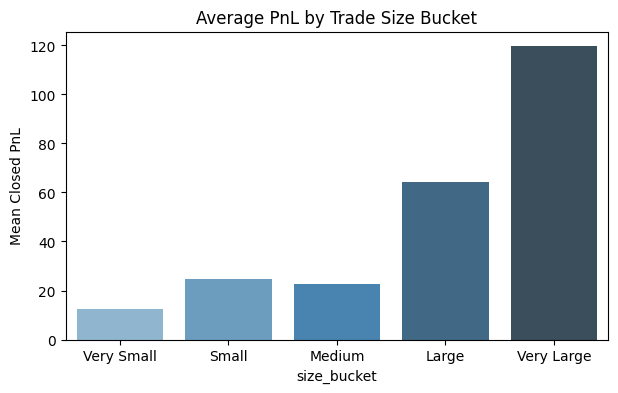

PnL by trade size bucket:
   size_bucket   closedPnL
0  Very Small   12.367309
1       Small   24.769593
2      Medium   22.514707
3       Large   64.289323
4  Very Large  119.603919


In [ ]:
if "closedPnL" in merged.columns:
    merged["size_bucket"] = pd.qcut(merged["size"], q=5, labels=["Very Small","Small","Medium","Large","Very Large"])

    size_perf = merged.groupby("size_bucket")["closedPnL"].mean().reset_index()

    plt.figure(figsize=(7,4))
    sns.barplot(data=size_perf, x="size_bucket", y="closedPnL", palette="Blues_d")
    plt.title("Average PnL by Trade Size Bucket")
    plt.ylabel("Mean Closed PnL")
    plt.savefig(os.path.join(OUTS,"pnl_by_size.png"))
    plt.show()

    print("PnL by trade size bucket:\n", size_perf)


In [ ]:
summary.to_csv(os.path.join(CSV_DIR, "performance_by_sentiment.csv"), index=False)
print("✅ performance_by_sentiment.csv saved")


✅ performance_by_sentiment.csv saved


**Profitability by Trade Size Buckets**

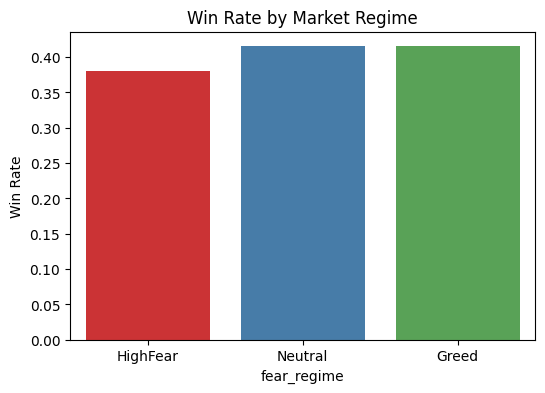

Win Rate by regime:
   fear_regime  win_rate
0    HighFear  0.379730
1     Neutral  0.415188
2       Greed  0.414905


In [ ]:
if "closedPnL" in merged.columns:
    win_rate_regime = merged.groupby("fear_regime")["closedPnL"].apply(lambda s:(s>0).mean()).reset_index()
    win_rate_regime.columns = ["fear_regime","win_rate"]

    plt.figure(figsize=(6,4))
    sns.barplot(data=win_rate_regime, x="fear_regime", y="win_rate", palette="Set1")
    plt.title("Win Rate by Market Regime")
    plt.ylabel("Win Rate")
    plt.savefig(os.path.join(OUTS,"winrate_by_regime.png"))
    plt.show()

    print("Win Rate by regime:\n", win_rate_regime)


**Win Rate by Sentiment Regime**

In [ ]:
import plotly.express as px

if "closedPnL" in merged.columns:
    fig = px.scatter(
        merged.sample(5000, random_state=42),
        x="fear_index", y="closedPnL", color="fear_class",
        title="PnL vs Fear Index (Sample of Trades)",
        labels={"fear_index":"Fear Index","closedPnL":"Closed PnL"},
        opacity=0.6
    )
    fig.show()


In [70]:
# Create README.md
readme_text = f"""
# 🚀 Trader Behavior Insights (Assignment)

This project explores the relationship between **Bitcoin market sentiment** (Fear & Greed Index)
and **trader performance** on Hyperliquid.

---

## 📊 Key Results
- Cross-validated ROC-AUC (XGBoost): {np.mean(aucs):.4f}
- Feature importance saved → `csv_files/feature_importance.csv`
- Sentiment performance CSV → `csv_files/performance_by_sentiment.csv`
- Plots saved → `outputs/`

---

## 📂 Project Structure
- csv_files/       → Contains performance CSVs and feature importance
- outputs/         → All generated plots
- README.md        → This file
"""

# Save to file
with open(os.path.join(OUT_ROOT,"README.md"), "w") as f:
    f.write(readme_text)

print("✅ README.md created successfully")


✅ README.md created successfully


# Task
Explain the provided directory structure and create the necessary directories.

## Create the root directory

### Subtask:
Create the main directory with the format `ds_<candidate_name>`.


**Reasoning**:
Create the main directory as specified in the instructions.



In [72]:
os.makedirs("/content/ds_LIKITHA", exist_ok=True)
print("✅ Root directory ds_LIKITHA created successfully")

✅ Root directory ds_LIKITHA created successfully


## Create subdirectories

### Subtask:
Inside the root directory, create the `csv_files` and `outputs` subdirectories.


**Reasoning**:
Create the variables for the subdirectory paths and create the subdirectories.



In [73]:
OUT_ROOT = "/content/ds_LIKITHA"
CSV_DIR = os.path.join(OUT_ROOT, "csv_files")
OUTS = os.path.join(OUT_ROOT, "outputs")
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUTS, exist_ok=True)
print("✅ Subdirectories csv_files and outputs created successfully")

✅ Subdirectories csv_files and outputs created successfully


In [74]:
print("Directory Structure:")
print(f"- {OUT_ROOT}/ (Root directory)")
print(f"  - Your main notebook file should be placed here.")
print(f"  - Your final report in PDF format should be placed here.")
print(f"  - {CSV_DIR}/ (Subdirectory for CSV files)")
print(f"    - All generated CSV files (e.g., performance_by_sentiment.csv, feature_importance.csv) should be saved here.")
print(f"  - {OUTS}/ (Subdirectory for image outputs)")
print(f"    - All generated image outputs (e.g., pnl_distribution.png, pnl_vs_fear.png, top_traders.png, sentiment_distribution.png, pnl_by_size.png, winrate_by_regime.png) should be saved here.")

Directory Structure:
- /content/ds_LIKITHA/ (Root directory)
  - Your main notebook file should be placed here.
  - Your final report in PDF format should be placed here.
  - /content/ds_LIKITHA/csv_files/ (Subdirectory for CSV files)
    - All generated CSV files (e.g., performance_by_sentiment.csv, feature_importance.csv) should be saved here.
  - /content/ds_LIKITHA/outputs/ (Subdirectory for image outputs)
    - All generated image outputs (e.g., pnl_distribution.png, pnl_vs_fear.png, top_traders.png, sentiment_distribution.png, pnl_by_size.png, winrate_by_regime.png) should be saved here.
